# Approximation Details

> In this notebook, I look at some details to validate the approximation hypothesis.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from collections import defaultdict
from functools import partial
import gc
from operator import itemgetter
from pathlib import Path
from typing import Callable, Dict, List, Optional, Iterable, Protocol, Sequence, Tuple, TypeVar, Type

In [ ]:
#| hide
from fastcore.test import *
import math
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import tempfile
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
    SubstringFrequencyAnalysis,
    top_nonzero_tokens
)
from transformer_experiments.common.utils import (
    aggregate_by_string_key,
    DataWrapper,
    topk_across_batches,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.models.transformer import (
    block_size,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer,
    FilenameForToken,
)
from transformer_experiments.training_utils import CheckPointer, GetBatchFunction, Trainer
from transformer_experiments.experiments.block_internals import (
    BlockInternalsAccessors,
    BlockInternalsExperiment,
    BatchedBlockInternalsExperiment,
    BlockInternalsAnalysis,
    batch_cosine_sim,
)
from transformer_experiments.experiments.cosine_sims import (
    filter_on_prefiltered_results,
    pre_filter_cosine_sim_results,
)
from transformer_experiments.experiments.final_ffwd import FinalFFWDExperiment
from transformer_experiments.experiments.similar_strings import (
    SimilarStringsData,
    SimilarStringsExperiment,
    SimilarStringsResult
)
from transformer_experiments.experiments.logit_lens import LogitLens

In [ ]:
environment = get_environment()
print(f"environment is {environment.name}")

environment is local_mac


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
# Get all the unique substrings of length 10 from the text
strings10 = all_unique_substrings(text=ts.text, substring_length=10)

In [ ]:
torch.manual_seed(1442)
n_prompts = 20000

torch.manual_seed(1337)
indices = torch.randperm(len(strings10))[:n_prompts]
prompts = [strings10[i.item()] for i in indices]
prompts[:5]

['is dreams,', 'by present', 's eyes may', 'eart of ho', ' man, as I']

In [ ]:
# Tokenize the strings
tokens = encoding_helpers.tokenize_strings(prompts)

# Embed the tokens
accessors = TransformerAccessors(m, device)
embeddings = accessors.embed_tokens(tokens)

# Run them through the model with hooks attached that let us look at
# intermediate values
_, io_accessors = accessors.run_model(embeddings)

In [ ]:
# Grab the outputs of the ffwd networks at each layer
ffwd_outs = []
for block_idx in range(n_layer):
    ffwd_outs.append(io_accessors[block_idx].output('ffwd')[:, -1, :].clone())

In [ ]:
len(ffwd_outs), len(ffwd_outs[0])

(6, 20000)

In [ ]:
# Free up some memory
del io_accessors
_ = gc.collect()

In [ ]:
prefiltered_threshold=0.7
prefiltered_results_folder = environment.data_root / 'cosine_sim_results/large_files/slen10' / f'prefiltered_{prefiltered_threshold}'

def prefiltered_filename(block_idx: int, q_idx: int) -> Path:
    return prefiltered_results_folder / f'cosine_sim_ffwd_out_{q_idx:05d}_{block_idx:02d}.pt'

def load_prefiltered_data(block_idx: int, q_idx: int):
    return torch.load(prefiltered_filename(block_idx, q_idx))

In [ ]:
similarity_thresholds=[0.95, 0.94, 0.85, 0.76, 0.81, 0.89]

In [ ]:
next_token_map10 = build_next_token_map(
    text=ts.text,
    prefix_len=10,
    vocab_size=tokenizer.vocab_size,
    stoi=tokenizer.stoi
)

In [ ]:
def hellinger_distance(
    p: torch.Tensor,
    q: torch.Tensor,
):
    return ((p.sqrt() - q.sqrt())**2).sum(dim=-1).sqrt() / math.sqrt(2)

In [ ]:
block_idx = 0
q_idx = 40
similar_indices = filter_on_prefiltered_results(
    load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
    q_idx_start=q_idx,
    q_idx_end=q_idx+1,
    filter_fn=lambda values: values > similarity_thresholds[block_idx]
)
similar_strings = [
    [strings10[i] for i in indices]
    for indices in similar_indices
]
len(similar_strings[0])

57

In [ ]:
total_freq_distribution = torch.stack([
    next_token_map10[string] for string in similar_strings[0]
]).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum()

In [ ]:
def plot_prob_distribution_for_tokens(
    prob_distribution: torch.Tensor,
    title: str = "",
    ax: Optional[Axes] = None,
    figsize=(12, 4),
):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    x_indices = np.arange(tokenizer.vocab_size)
    x_labels = [repr(c)[1:-1] for c in tokenizer.chars]

    ax.bar(x_indices, prob_distribution)
    ax.set_xticks(x_indices, x_labels, rotation="vertical")
    ax.set_title(title)
    ax.set_ylim(0.0, 1.0)

    return ax

<Axes: title={'center': 'Probability distribution from approximation'}>

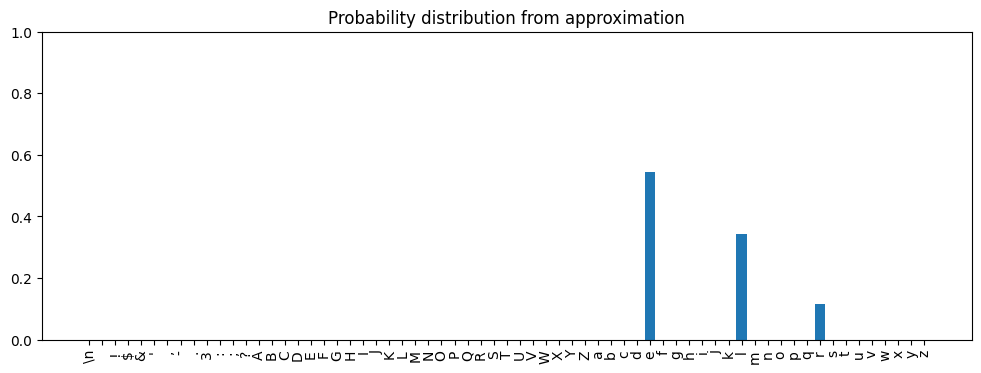

In [ ]:
plot_prob_distribution_for_tokens(prob_distribution, title="Probability distribution from approximation")

In [ ]:
ffwd_outs[block_idx][q_idx].shape

torch.Size([384])

In [ ]:
logits = accessors.logits_from_embedding(ffwd_outs[block_idx][q_idx])
logits = LogitsWrapper(
    unsqueeze_emb(logits, expected_last_dim_size=tokenizer.vocab_size),
    tokenizer,
)

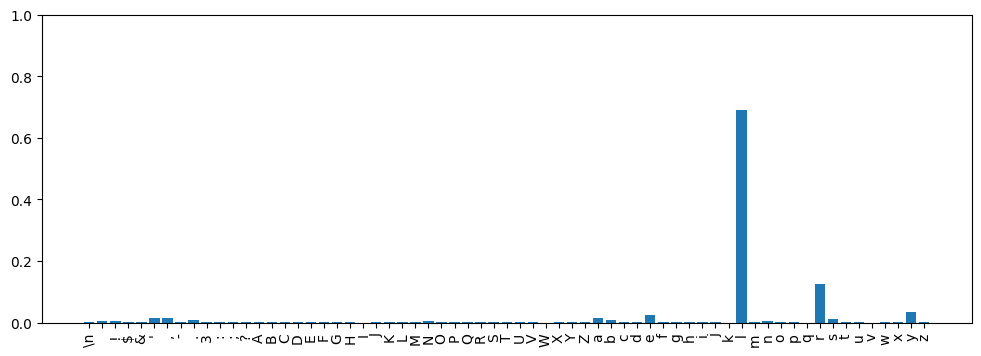

In [ ]:
logits.plot_probs()

In [ ]:
hellinger_distance(prob_distribution, logits.probs()[0, 0])

tensor(0.5305)

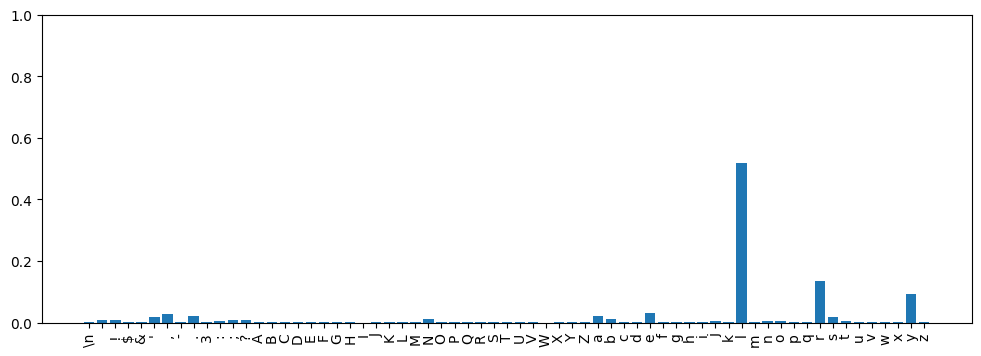

In [ ]:
block_out = io_accessors[block_idx].output('.')[q_idx, -1, :]
logits = accessors.logits_from_embedding(unsqueeze_emb(block_out))
logits = LogitsWrapper(logits, tokenizer)
logits.plot_probs()

In [ ]:
hellinger_distance(prob_distribution, logits.probs()[0, 0])

tensor(0.5681)

In [ ]:
blocks, _ = zip(
    *[
        accessors.copy_block_from_model(block_idx=i)
        for i in range(1, n_layer)
    ]
)
blocks_module = torch.nn.Sequential(*blocks)

run_rest_of_model = lambda x: accessors.logits_from_embedding(blocks_module(x)).detach()


In [ ]:
logits1 = run_rest_of_model(unsqueeze_emb(block_out))
logits1 = LogitsWrapper(logits1, tokenizer)

logits2 = run_rest_of_model(unsqueeze_emb(block_out - ffwd_outs[block_idx][q_idx]))
logits2 = LogitsWrapper(logits2, tokenizer)

In [ ]:
logits_diff = (logits1.logits - logits2.logits)[0, 0]

In [ ]:
logits_diff.shape

torch.Size([65])

In [ ]:
prob_diff = (logits1.probs() - logits2.probs())[0, 0]

In [ ]:
prob_diff.shape

torch.Size([65])

(-1.0, 1.0)

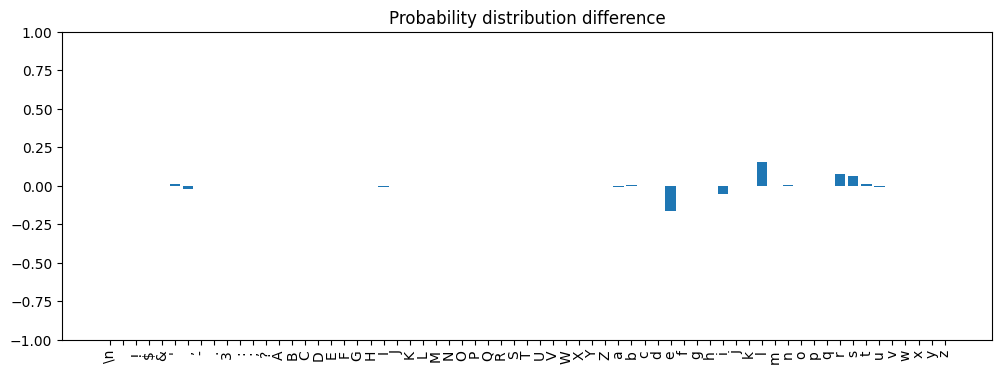

In [ ]:
ax = plot_prob_distribution_for_tokens(prob_diff, title="Probability distribution difference")
ax.set_ylim(-1.0, 1.0)

## Analysis Using Learned Embeddings

### Compute Singular Vectors

In [ ]:
learned_embeddings_dir = environment.data_root / 'learned_embeddings'
assert learned_embeddings_dir.exists()

In [ ]:
filename_for_token = FilenameForToken(tokenizer)

In [ ]:
def top_right_singular_vector(multi_embs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    U, S, V = torch.linalg.svd(multi_embs[:, 0, :], full_matrices=True)
    sign = 1 if F.cosine_similarity(V[0], multi_embs[0, 0, :], dim=-1) > 0 else -1
    return sign*V[0], S # top right singular vector and singular values

#### No Blocks

In [ ]:
no_blocks_dir = learned_embeddings_dir / 'no_blocks'
assert no_blocks_dir.exists()


In [ ]:
no_blocks_embeddings = {}
for char in tokenizer.chars:
    multi_embs = torch.load(no_blocks_dir / f"{filename_for_token(char)}.pt", map_location=torch.device('cpu'))
    no_blocks_embeddings[char] = top_right_singular_vector(multi_embs)


#### 1 Block

In [ ]:
block5_dir = learned_embeddings_dir / 'block_5'
assert block5_dir.exists()

In [ ]:
block5_embeddings = {}
for char in tokenizer.chars:
    multi_embs = torch.load(block5_dir / f"{filename_for_token(char)}.pt", map_location=torch.device('cpu'))
    block5_embeddings[char] = top_right_singular_vector(multi_embs)

In [ ]:
block5_1000_dir = learned_embeddings_dir / 'block_5_1000'
assert block5_dir.exists()

In [ ]:
block5_1000_embeddings = {}
for char in tokenizer.chars:
    multi_embs = torch.load(block5_1000_dir / f"{filename_for_token(char)}.pt", map_location=torch.device('cpu'))
    block5_1000_embeddings[char] = top_right_singular_vector(multi_embs)

In [ ]:
block5_5000_dir = learned_embeddings_dir / 'block_5_5000'
assert block5_dir.exists()

In [ ]:
block5_5000_embeddings = {}
for char in tokenizer.chars:
    multi_embs = torch.load(block5_5000_dir / f"{filename_for_token(char)}.pt", map_location=torch.device('cpu'))
    block5_5000_embeddings[char] = top_right_singular_vector(multi_embs)

#### 2 Block

In [ ]:
block4_dir = learned_embeddings_dir / 'block_4'
assert block4_dir.exists()

In [ ]:
block4_embeddings = {}
for char in tokenizer.chars:
    multi_embs = torch.load(block4_dir / f"{filename_for_token(char)}.pt", map_location=torch.device('cpu'))
    block4_embeddings[char] = top_right_singular_vector(multi_embs)

#### Examples

In [ ]:
block_idx = 5
q_idx = 36
similar_indices = filter_on_prefiltered_results(
    load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
    q_idx_start=q_idx,
    q_idx_end=q_idx+1,
    filter_fn=lambda values: values > similarity_thresholds[block_idx]
)
similar_strings = [
    [strings10[i] for i in indices]
    for indices in similar_indices
]
len(similar_strings[0])

823

In [ ]:
total_freq_distribution = torch.stack([
    next_token_map10[string] for string in similar_strings[0]
]).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum()

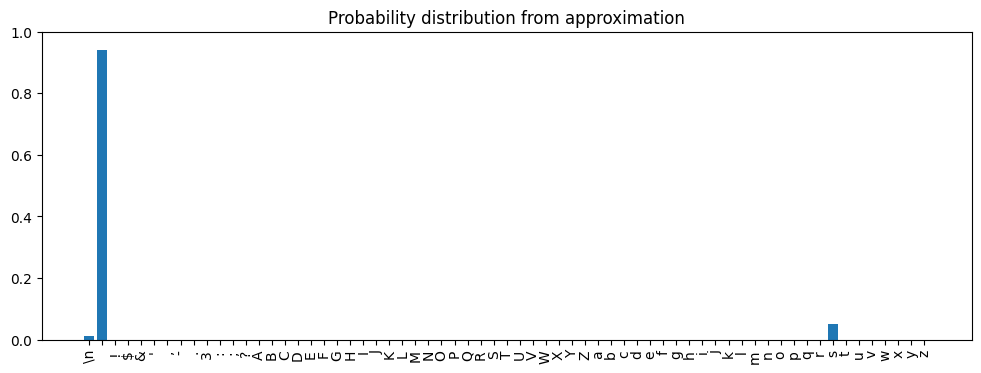

In [ ]:
_ = plot_prob_distribution_for_tokens(prob_distribution, title="Probability distribution from approximation")

In [ ]:
cosine_sims = torch.tensor([
    F.cosine_similarity(
        no_blocks_embeddings[char][0],
        ffwd_outs[block_idx][q_idx],
        dim=-1
    )
    for char in tokenizer.chars
])


In [ ]:
values, indices = torch.topk(cosine_sims, k=10)
values, indices

(tensor([0.5869, 0.4769, 0.3841, 0.1046, 0.0988, 0.0976, 0.0962, 0.0938, 0.0870,
         0.0818]),
 tensor([ 1, 57,  0,  7, 58,  5, 47,  8, 51, 31]))

In [ ]:
[tokenizer.itos[i.item()] for i in indices]

[' ', 's', '\n', '-', 't', "'", 'i', '.', 'm', 'S']

In [ ]:
no_blocks_embeddings['a'][0].shape

torch.Size([384])

In [ ]:
ffwd_outs[block_idx][q_idx].shape

torch.Size([384])

In [ ]:
block_idx = 4
q_idx = 72
similar_indices = filter_on_prefiltered_results(
    load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
    q_idx_start=q_idx,
    q_idx_end=q_idx+1,
    filter_fn=lambda values: values > similarity_thresholds[block_idx]
)
similar_strings = [
    [strings10[i] for i in indices]
    for indices in similar_indices
]
len(similar_strings[0])

11

In [ ]:
total_freq_distribution = torch.stack([
    next_token_map10[string] for string in similar_strings[0]
]).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum()

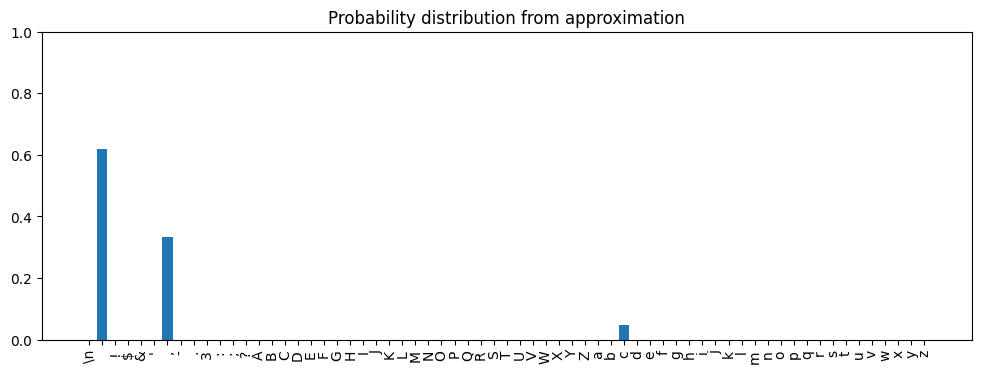

In [ ]:
_ = plot_prob_distribution_for_tokens(prob_distribution, title="Probability distribution from approximation")

In [ ]:
cosine_sims = torch.tensor([
    F.cosine_similarity(
        block5_embeddings[char][0],
        ffwd_outs[block_idx][q_idx],
        dim=-1
    )
    for char in tokenizer.chars
])

In [ ]:
values, indices = torch.topk(cosine_sims, k=10)
values, indices

(tensor([0.2572, 0.2508, 0.1864, 0.1667, 0.1653, 0.1064, 0.1052, 0.0974, 0.0948,
         0.0750]),
 tensor([ 2, 41,  6, 39, 11, 62, 12, 36,  8, 54]))

In [ ]:
[tokenizer.itos[i.item()] for i in indices]

['!', 'c', ',', 'a', ';', 'x', '?', 'X', '.', 'p']

In [ ]:
cosine_sims = torch.tensor([
    F.cosine_similarity(
        block5_1000_embeddings[char][0],
        ffwd_outs[block_idx][q_idx],
        dim=-1
    )
    for char in tokenizer.chars
])

In [ ]:
values, indices = torch.topk(cosine_sims, k=10)
values, indices, [tokenizer.itos[i.item()] for i in indices]

(tensor([0.2614, 0.2589, 0.1958, 0.1935, 0.1618, 0.1106, 0.1100, 0.1007, 0.0906,
         0.0814]),
 tensor([ 2, 41,  6, 39, 11, 36, 62,  8, 49, 12]),
 ['!', 'c', ',', 'a', ';', 'X', 'x', '.', 'k', '?'])

In [ ]:
cosine_sims = torch.tensor([
    F.cosine_similarity(
        block5_5000_embeddings[char][0],
        ffwd_outs[block_idx][q_idx],
        dim=-1
    )
    for char in tokenizer.chars
])

In [ ]:
values, indices = torch.topk(cosine_sims, k=10)
values, indices, [tokenizer.itos[i.item()] for i in indices]

(tensor([0.2635, 0.2621, 0.2016, 0.1848, 0.1595, 0.1087, 0.1087, 0.1022, 0.0885,
         0.0876]),
 tensor([41,  2,  6, 39, 11, 62, 36,  8, 12, 49]),
 ['c', '!', ',', 'a', ';', 'x', 'X', '.', '?', 'k'])

In [ ]:
def plot_singular_values(singular_values: Iterable[torch.Tensor], title: str=''):
    fig = plt.figure(figsize=(12, 4))

    x_indices = np.arange(len(singular_values[0]))
    ax = fig.add_subplot(1, 1, 1)
    width = 1.0 / len(singular_values)
    for i, s in enumerate(singular_values):
        ax.bar(x_indices + i*width, s)

    ax.set_title(title)
    return ax

<Axes: title={'center': 'No Blocks Singular values for l'}>

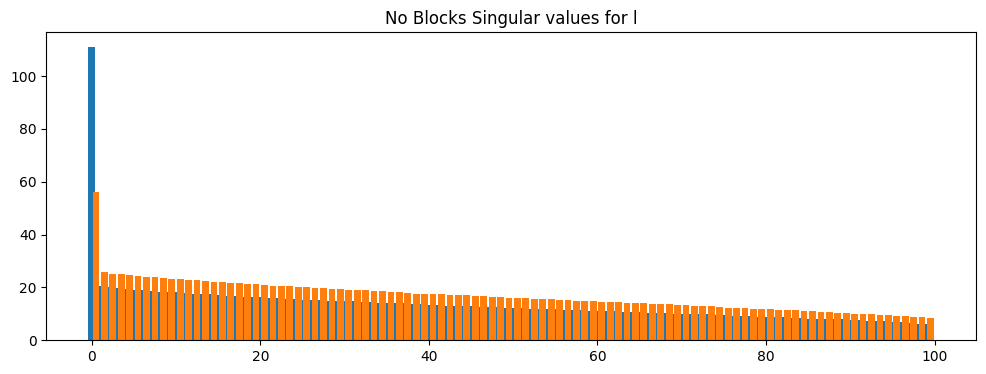

In [ ]:
char = 'l'
plot_singular_values(
    [no_blocks_embeddings[char][1], block5_embeddings[char][1]],
    title=f"No Blocks Singular values for {char}"
)


My suspicion is that for the block 5 case, just the first singular vector is not a good approximation of the subspace of the embedding space that produces the target character. Maybe we need to use more of the singular vectors. 

In [ ]:
def projection_matrix_from_multi_emb(multi_embs: torch.Tensor, k: int) -> torch.Tensor:
    _, _, V = torch.linalg.svd(multi_embs[:, 0, :], full_matrices=True)
    basis_vectors = []
    for i in range(k):
        basis_vectors.append(V[i])

    A = torch.stack(basis_vectors).T

    return A @ (A.T @ A).inverse() @ A.T


In [ ]:
def multi_embs_for_char(char: str, embeddings_dir: Path) -> torch.Tensor:
    return torch.load(embeddings_dir / f"{filename_for_token(char)}.pt", map_location=torch.device('cpu'))

In [ ]:
v1 = torch.tensor([1.0, 2.0, 3.0])
v2 = torch.tensor([4.0, 5.0, 6.0])
torch.stack([v1, v2]).T

tensor([[1., 4.],
        [2., 5.],
        [3., 6.]])

In [ ]:
multi_emb_l = multi_embs_for_char('l', block5_dir)
multi_emb_l.shape

torch.Size([100, 1, 384])

In [ ]:
p = projection_matrix_from_multi_emb(multi_emb_l, k=2)

In [ ]:
p.shape

torch.Size([384, 384])

In [ ]:
proj = p @ ffwd_outs[block_idx][q_idx]
proj.shape

torch.Size([384])

In [ ]:
(ffwd_outs[block_idx][q_idx] - proj).norm()

tensor(4.7440)

In [ ]:
compare_char = '$'
p = projection_matrix_from_multi_emb(multi_embs_for_char(compare_char, block5_dir), k=2)
proj = p @ ffwd_outs[block_idx][q_idx]
(ffwd_outs[block_idx][q_idx] - proj).norm()

tensor(5.3079)

In [ ]:
k=3
distances = []
for char in tokenizer.chars:
    p = projection_matrix_from_multi_emb(multi_embs_for_char(char, block5_dir), k=3)
    proj = p @ ffwd_outs[block_idx][q_idx]
    distances.append((ffwd_outs[block_idx][q_idx] - proj).norm())
distances = torch.tensor(distances)
values, indices = torch.topk(distances, k=10, largest=False)
values, indices, [tokenizer.itos[i.item()] for i in indices]

(tensor([5.0757, 5.0769, 5.0839, 5.0950, 5.0962, 5.0977, 5.1026, 5.1049, 5.1082,
         5.1091]),
 tensor([56, 46,  1,  9, 50, 25, 23,  8, 54, 62]),
 ['r', 'h', ' ', '3', 'l', 'M', 'K', '.', 'p', 'x'])

In [ ]:
k=1
norms = []
for char in tokenizer.chars:
    p = projection_matrix_from_multi_emb(multi_embs_for_char(char, block5_dir), k=k)
    proj = p @ ffwd_outs[block_idx][q_idx]
    norms.append(proj.norm())
norms = torch.tensor(norms)
values, indices = torch.topk(norms, k=10)
values, indices, [tokenizer.itos[i.item()] for i in indices]

(tensor([1.1238, 1.0957, 0.8145, 0.7285, 0.7222, 0.6194, 0.4649, 0.4595, 0.4380,
         0.4272]),
 tensor([ 2, 41,  6, 39, 11, 21, 62, 12, 35, 27]),
 ['!', 'c', ',', 'a', ';', 'I', 'x', '?', 'W', 'O'])

In [ ]:
k=3
norms = []
for char in tokenizer.chars:
    p = projection_matrix_from_multi_emb(multi_embs_for_char(char, block5_dir)[:100, :, :], k=k)
    proj = p @ ffwd_outs[block_idx][q_idx]
    norms.append(proj.norm())
norms = torch.tensor(norms)
values, indices = torch.topk(norms, k=65)
values, indices, [tokenizer.itos[i.item()] for i in indices]

(tensor([1.1559, 1.0963, 1.0274, 0.8432, 0.8290, 0.8286, 0.8207, 0.7537, 0.6604,
         0.6285, 0.6125, 0.5953, 0.5893, 0.5789, 0.5750, 0.5671, 0.5521, 0.5327,
         0.5221, 0.5150, 0.4902, 0.4888, 0.4858, 0.4847, 0.4805, 0.4743, 0.4590,
         0.4517, 0.4470, 0.4421, 0.4419, 0.4396, 0.4363, 0.4298, 0.4124, 0.4047,
         0.3980, 0.3940, 0.3810, 0.3764, 0.3715, 0.3552, 0.3517, 0.3413, 0.3364,
         0.3346, 0.3338, 0.3138, 0.3085, 0.2962, 0.2953, 0.2792, 0.2736, 0.2721,
         0.2709, 0.2653, 0.2204, 0.2120, 0.1994, 0.1870, 0.1676, 0.1610, 0.1509,
         0.0991, 0.0770]),
 tensor([ 2, 41,  8, 29, 11,  6, 39, 21, 51, 46, 54, 10, 38, 55, 36, 43, 30, 12,
         32, 62, 40, 61,  3, 45, 16,  4,  9, 35, 60, 52, 24, 22, 49, 27, 47, 31,
         14, 48, 23, 17, 13, 53, 44, 26, 18, 37, 20, 57, 28, 59, 64, 15, 63,  7,
         42, 58, 25, 19,  1, 50,  0, 33, 56,  5, 34]),
 ['!',
  'c',
  '.',
  'Q',
  ';',
  ',',
  'a',
  'I',
  'm',
  'h',
  'p',
  ':',
  'Z',
  'q',
  'X',
  '

In [ ]:
k=3
target=ffwd_outs[block_idx][q_idx]
results_dir=block5_dir
use_n_embs=100
norms = []
for char in tokenizer.chars:
    p = projection_matrix_from_multi_emb(multi_embs_for_char(char, results_dir)[:use_n_embs, :, :], k=k)
    proj = p @ target
    norms.append(proj.norm())
norms = torch.tensor(norms)
values, indices = torch.topk(norms, k=65)
values, indices, [tokenizer.itos[i.item()] for i in indices]

(tensor([2.3661, 1.7985, 1.7774, 1.6871, 1.6380, 1.6304, 1.6047, 1.4994, 1.4495,
         1.4171, 1.3473, 1.3419, 1.3260, 1.2587, 1.2499, 1.1820, 1.1239, 1.1118,
         1.0701, 1.0608, 1.0531, 1.0465, 1.0444, 1.0211, 1.0078, 1.0045, 0.9660,
         0.9489, 0.9380, 0.9242, 0.9043, 0.8980, 0.8724, 0.8324, 0.8271, 0.8117,
         0.7984, 0.7797, 0.7726, 0.7489, 0.7341, 0.7202, 0.6846, 0.6711, 0.5837,
         0.5641, 0.5489, 0.5488, 0.5348, 0.5309, 0.4719, 0.4555, 0.4500, 0.4090,
         0.3959, 0.3957, 0.3921, 0.3512, 0.3416, 0.3167, 0.3082, 0.2975, 0.2243,
         0.2238, 0.0750]),
 tensor([39,  1, 56, 33, 43,  6, 47, 15, 64, 13,  8,  9, 21,  0, 22, 48, 12, 41,
         62, 61, 29, 10,  2, 37, 52, 24,  3, 59, 16, 25,  5,  4, 49, 14, 30, 23,
         51, 54, 19, 18, 27, 63, 38, 57, 34, 20, 36, 17, 44,  7, 58, 45, 31, 55,
         60, 50, 53, 40, 46, 26, 35, 42, 32, 11, 28]),
 ['a',
  ' ',
  'r',
  'U',
  'e',
  ',',
  'i',
  'C',
  'z',
  'A',
  '.',
  '3',
  'I',
  '\n',
  'J',
  

In [ ]:
io_accessors[block_idx].output('.')[q_idx, -1, :].shape

In [ ]:
block5_1000_dir = learned_embeddings_dir / 'block_5_1000'
assert block5_1000_dir.exists()

In [ ]:
multi_emb_G_1000 = multi_embs_for_char('G', block5_1000_dir)
multi_emb_G_1000.shape

torch.Size([1000, 1, 384])

<Axes: title={'center': 'Block 5 1000 Singular values for G'}>

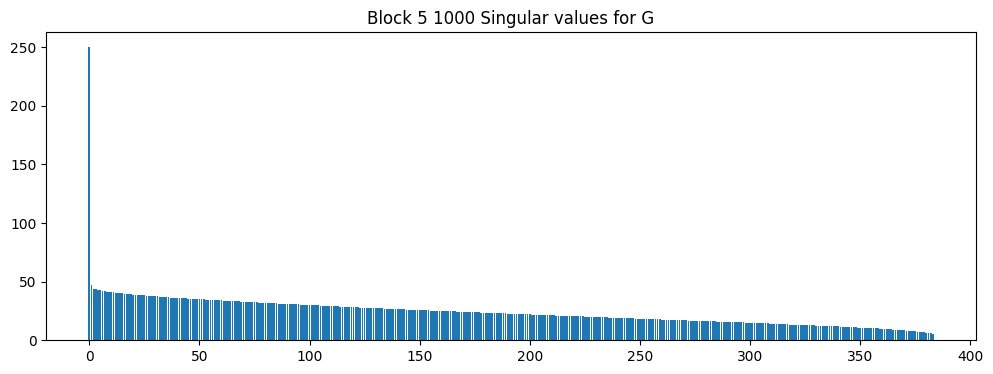

In [ ]:
_, S, V = torch.linalg.svd(multi_emb_G_1000[:, 0, :], full_matrices=True)
plot_singular_values(
    [S],
    title=f"Block 5 1000 Singular values for G"
)

<Axes: title={'center': 'Block 5 100 Singular values for G'}>

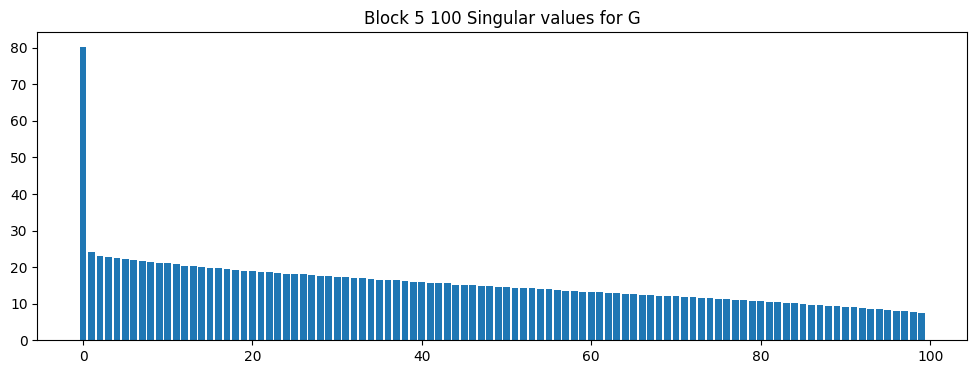

In [ ]:
_, S, V = torch.linalg.svd(multi_embs_for_char('G', block5_dir)[:, 0, :], full_matrices=True)
plot_singular_values(
    [S],
    title=f"Block 5 100 Singular values for G"
)

<Axes: title={'center': 'No Blocks Singular values for G'}>

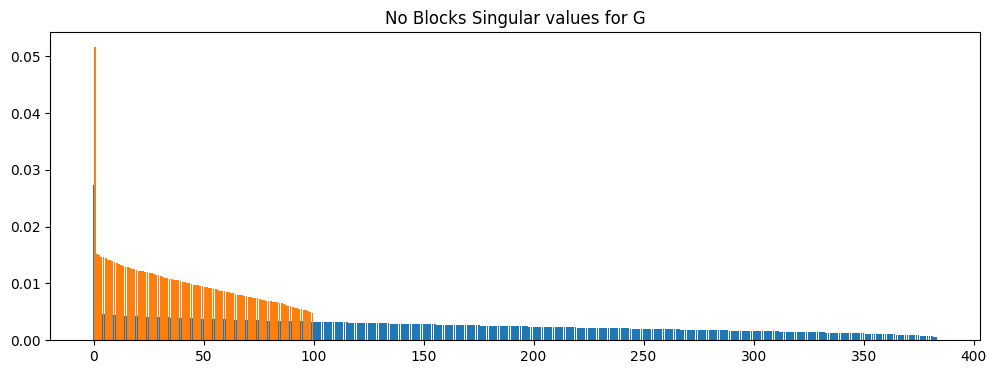

In [ ]:
token = 'L'
s1 = torch.linalg.svd(multi_embs_for_char(token, block5_1000_dir)[:, 0, :], full_matrices=True)[1]
s2 = torch.linalg.svd(multi_embs_for_char(token, block5_dir)[:, 0, :], full_matrices=True)[1]

if s2.shape[0] < s1.shape[0]:
    padded = torch.zeros_like(s1)
    padded[:s2.shape[0]] = s2
    s2 = padded

plot_singular_values(
    [
        s1 / s1.sum(), s2 / s2.sum()
    ],
    title=f"No Blocks Singular values for G"
)

<matplotlib.legend.Legend>

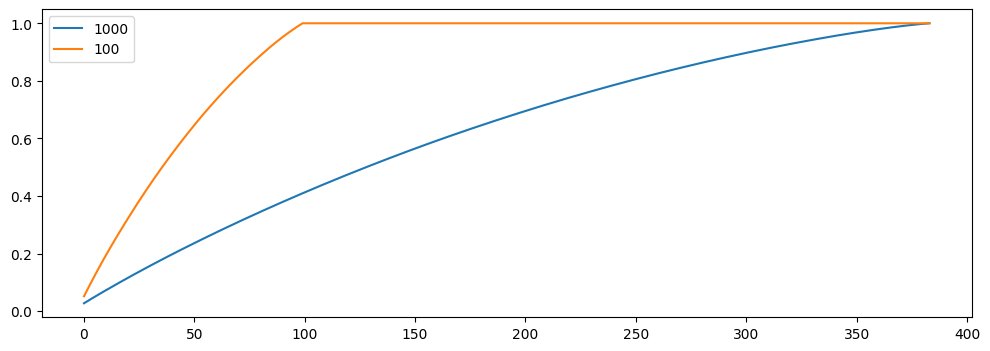

In [ ]:
norm_s1 = s1 / s1.sum()
norm_s2 = s2 / s2.sum()

# plot the cumulative sums of norm_s1 and norm_s2
fig = plt.figure(figsize=(12, 4))

x_indices = np.arange(len(norm_s1))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_indices, norm_s1.cumsum(dim=0))
ax.plot(x_indices, norm_s2.cumsum(dim=0))
ax.legend(['1000', '100'])


In [ ]:
torch.linalg.svd(multi_embs_for_char(token, block5_dir)[:, 0, :], full_matrices=True)[1].shape, torch.linalg.svd(multi_embs_for_char(token, block5_1000_dir)[:, 0, :], full_matrices=True)[1].shape

(torch.Size([100]), torch.Size([384]))

In [ ]:
U, S, V = torch.linalg.svd(multi_embs_for_char(token, block5_dir)[:, 0, :], full_matrices=True)
U.shape

torch.Size([100, 100])

In [ ]:
block4_dir = learned_embeddings_dir / 'block_4'
assert block4_dir.exists()

<Axes: title={'center': 'Block 4 100 Singular values for G'}>

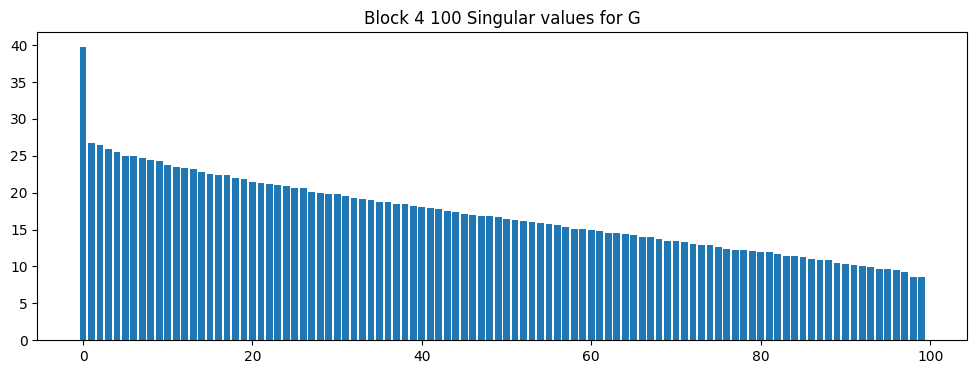

In [ ]:
_, S, V = torch.linalg.svd(multi_embs_for_char('l', block4_dir)[:, 0, :], full_matrices=True)
plot_singular_values(
    [S],
    title=f"Block 4 100 Singular values for G"
)

<Axes: title={'center': 'Block 4 100 Singular values for G'}>

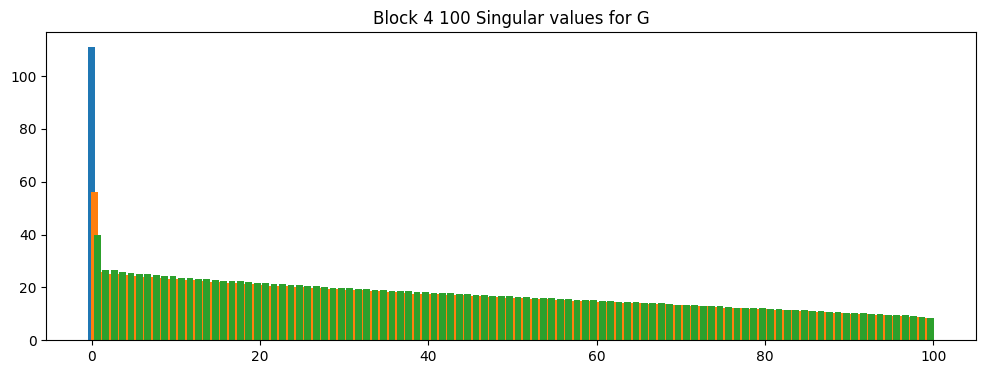

In [ ]:
_, S, V = torch.linalg.svd(multi_embs_for_char('l', block4_dir)[:, 0, :], full_matrices=True)
plot_singular_values(
    [
        torch.linalg.svd(multi_embs_for_char('l', no_blocks_dir)[:, 0, :], full_matrices=True)[1],
        torch.linalg.svd(multi_embs_for_char('l', block5_dir)[:, 0, :], full_matrices=True)[1],
        torch.linalg.svd(multi_embs_for_char('l', block4_dir)[:, 0, :], full_matrices=True)[1],
    ],
    title=f"Block 4 100 Singular values for G"
)

In [ ]:
block_idx = 3
q_idx = 88
similar_indices = filter_on_prefiltered_results(
    load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
    q_idx_start=q_idx,
    q_idx_end=q_idx+1,
    filter_fn=lambda values: values > similarity_thresholds[block_idx]
)
similar_strings = [
    [strings10[i] for i in indices]
    for indices in similar_indices
]
len(similar_strings[0])

54

In [ ]:
total_freq_distribution = torch.stack([
    next_token_map10[string] for string in similar_strings[0]
]).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum()

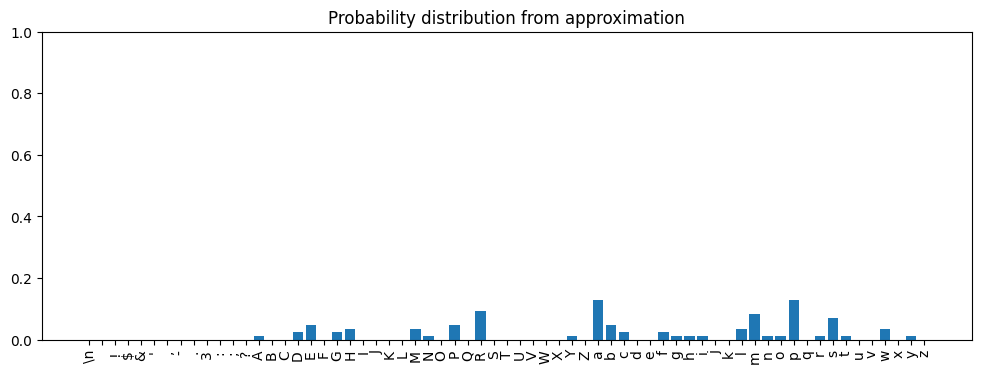

In [ ]:
_ = plot_prob_distribution_for_tokens(prob_distribution, title="Probability distribution from approximation")

In [ ]:
cosine_sims = torch.tensor([
    F.cosine_similarity(
        block5_embeddings[char][0],
        ffwd_outs[block_idx][q_idx],
        dim=-1
    )
    for char in tokenizer.chars
])

In [ ]:
values, indices = torch.topk(cosine_sims, k=10)
values, indices, [tokenizer.itos[i.item()] for i in indices]

(tensor([0.1375, 0.0951, 0.0912, 0.0865, 0.0840, 0.0793, 0.0791, 0.0757, 0.0640,
         0.0571]),
 tensor([25, 18, 15, 20, 40, 17, 19, 14, 51, 32]),
 ['M', 'F', 'C', 'H', 'b', 'E', 'G', 'B', 'm', 'T'])